In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import warnings
 # Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\wenruliu\adult-income-dataset\versions\2


In [ ]:
warnings.filterwarnings('ignore')
df = pd.read_csv(fr'{path}\adult.csv')

def prepocessing(df):
    # remove linhas
    df.drop(columns=['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week'], inplace = True)

    # filtra as colunas que possuem '?'
    fill_rows = ~(df == '?').any(axis = 1)
    df = df[fill_rows]

    # transforma as variáveis categoricas em numéricas 
    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
          df[col], _ = pd.factorize(df[col])

    return df

def split_train_test(df, test_size=0.3):
    # 1. Embaralha o DataFrame inteiro aleatoriamente
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 2. Calcula o ponto de corte
    len_df = len(shuffled_df)
    cut_point = len_df - round(len_df * test_size)

    # 3. Divide o DataFrame embaralhado
    train = shuffled_df[:cut_point]
    test = shuffled_df[cut_point:]

    print(f'Tamanho total: {len(df)}')
    print(f'Tamanho do treino: {len(train)}')
    print(f'Tamanho do teste: {len(test)}')

    return train, test

df = prepocessing(df)
X_train, X_test = split_train_test(df)

Tamanho total: 45222
Tamanho do treino: 31655
Tamanho do teste: 13567


In [ ]:
class KNN_DP():
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float32)
        self.y_train = np.array(y)

    def get_vizinhos_indices_vectorized(self, test_row):
        r = 6 # raio 

        diferencas = self.X_train - test_row
        dist_sq = np.sum(diferencas**2, axis=1)

        # filtra os pontos dentro do raio
        indices = np.where(dist_sq <= r**2)[0]
        return indices

    def predict_instance(self, test_row):
        # Busca índices rápidos
        indices = self.get_vizinhos_indices_vectorized(test_row)
        classes_vizinhas = self.y_train[indices]

        # Votação majoritária simples
        valores, contagens = np.unique(classes_vizinhas, return_counts=True)
        indice_vencedor = np.argmax(contagens)
        return valores[indice_vencedor]

    def predict_instance_private(self, test_row, epsilon):
        # Busca índices
        indices = self.get_vizinhos_indices_vectorized(test_row)
        classes_vizinhas = self.y_train[indices]

        # Classes possíveis
        valores_unicos = np.unique(self.y_train)
        L = len(valores_unicos)

        # Contagens reais
        contagens = {val: 0 for val in valores_unicos}
        for cls in classes_vizinhas:
            contagens[cls] += 1

        # Composição sequencial
        epsilon_por_classe = epsilon / L
        scale = 1.0 / epsilon_por_classe  # = Δf / epsilon

        # Contagens ruidosas
        contagens_ruidosas = {}
        for cls in contagens:
            ruido = np.random.laplace(loc=0.0, scale=scale)
            contagens_ruidosas[cls] = contagens[cls] + ruido

        return contagens, contagens_ruidosas


    def predict(self, X_test):
        X_test = np.array(X_test, dtype=np.float32)
        predicoes = []
        total = len(X_test)

        print("Iniciando predição padrão...")
        for i, row in enumerate(X_test):
            pred = self.predict_instance(row)
            predicoes.append(pred)
            if i % 1000 == 0: # Log de progresso
                print(f"Progresso: {i}/{total}", end='\r')

        return np.array(predicoes)

    def predict_private(self, X_test, epsilon):
        X_test = np.array(X_test, dtype=np.float32)

        predicoes_privadas = [] # Armazenando predições únicas

        total = len(X_test)
        print(f"Iniciando predição privada (eps={epsilon})...")

        for i, row in enumerate(X_test):
            contagens_reais, contagens_ruidosas = self.predict_instance_private(row, epsilon)

            # Determina a class predita da contagem ruidosa
            predicted_class = None
            max_noisy_count = -np.inf
            for cls_val, noisy_count in contagens_ruidosas.items():
                if noisy_count > max_noisy_count:
                    max_noisy_count = noisy_count
                    predicted_class = cls_val
            
            predicoes_privadas.append(predicted_class)

            if i % 1000 == 0:
                print(f"Progresso: {i}/{total}", end='\r')

        return np.array(predicoes_privadas) # Array de Predições 

# 1. Preparação correta dos dados
# .values garante que seja array numpy, evitando índices do pandas
y_train = X_train['age'].values
x_train = X_train.drop(columns=['age']).values

y_test = X_test['age'].values
x_test = X_test.drop(columns=['age']).values

k = 10
model = KNN_DP(k=k)

# Treinamento
print("Treinando modelo...")
model.fit(x_train, y_train)

# 1. Execução KNN Tradicional
print("Executando KNN Tradicional...")

y_pred_padrao = model.predict(x_test)

# Salvando resultado tradicional
df_resultado = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_padrao
})
df_resultado.to_csv('resultado_knn_tradicional.csv', index=False)
print("\nResultado Tradicional salvo.")

epsilons = [0.5, 1, 1.5, 2.0, 2.5, 3.0]

for eps in epsilons:
    print(f"\nExecutando KNN Privado (epsilon={eps})...")

    y_pred_privado = model.predict_private(x_test, epsilon=eps)

    # Salvando resultado privado
    nome_arquivo = f'resultado_knn_laplace_eps_{eps}.csv'
    df_resultado_priv = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_pred_privado
    })
    df_resultado_priv.to_csv(nome_arquivo, index=False)
    print(f"\nArquivo {nome_arquivo} salvo.")

print("Processo finalizado.")

Treinando modelo...
Executando KNN Tradicional...
Iniciando predição padrão...
Progresso: 13000/13567
Resultado Tradicional salvo.

Executando KNN Privado (epsilon=0.5)...
Iniciando predição privada (eps=0.5)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_0.5.csv salvo.

Executando KNN Privado (epsilon=1)...
Iniciando predição privada (eps=1)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_1.csv salvo.

Executando KNN Privado (epsilon=1.5)...
Iniciando predição privada (eps=1.5)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_1.5.csv salvo.

Executando KNN Privado (epsilon=2.0)...
Iniciando predição privada (eps=2.0)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_2.0.csv salvo.

Executando KNN Privado (epsilon=2.5)...
Iniciando predição privada (eps=2.5)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_2.5.csv salvo.

Executando KNN Privado (epsilon=3.0)...
Iniciando predição privada (eps=3.0)...
Progresso: 13000/13567
Arquiv

In [21]:
def acuracia(pred, y_target):
    return  sum(pred == y_target)/len(y_target)

df = pd.read_csv('resultado_knn_tradicional.csv')
acr = acuracia(df['y_pred'].values, df['y_true'].values)
print(f'Acurácia dataset original: {acr}')

print(f"Resultado datasets...")

epsilons = [0.5, 1, 1.5, 2.0, 2.5, 3.0]
for eps in epsilons:
    
     # Salvando resultado privado
    df_epsilon = pd.read_csv(f'resultado_knn_laplace_eps_{eps}.csv')
    acr = acuracia(df_epsilon['y_pred'].values, df_epsilon['y_true'].values)
    print(f'Acurácia dataset ε={eps}: {acr}')

print("Processo finalizado.")

Acurácia dataset original: 0.03619075698385789
Resultado datasets...
Acurácia dataset ε=0.5: 0.022923269698533207
Acurácia dataset ε=1: 0.02697722414682686
Acurácia dataset ε=1.5: 0.028598805926144322
Acurácia dataset ε=2.0: 0.028525097663448074
Acurácia dataset ε=2.5: 0.03213680253556424
Acurácia dataset ε=3.0: 0.03287388516252672
Processo finalizado.


Acurácia Tradicional: 0.0362
Acurácia (eps=0.5): 0.0229
Acurácia (eps=1): 0.0270
Acurácia (eps=1.5): 0.0286
Acurácia (eps=2.0): 0.0285
Acurácia (eps=2.5): 0.0321
Acurácia (eps=3.0): 0.0329


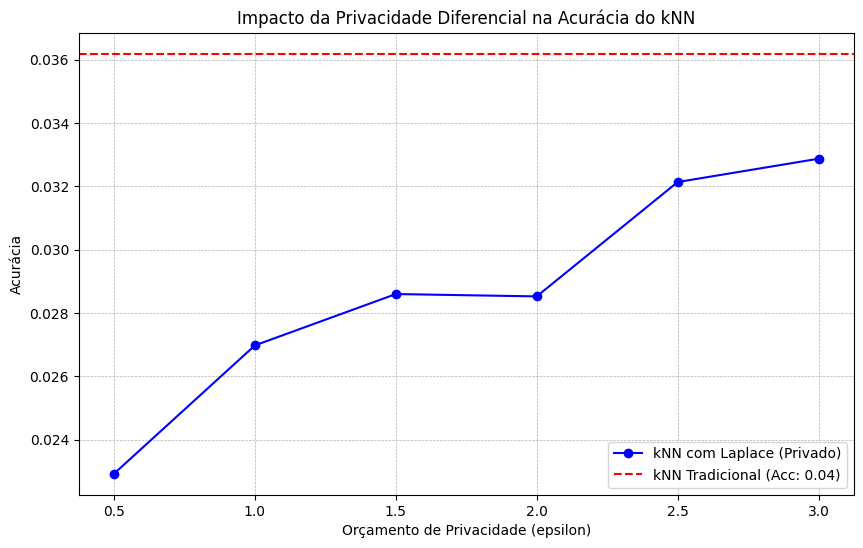

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Definição dos epsilons usados
epsilons = [0.5, 1, 1.5 ,2.0, 2.5, 3.0]

# Lista para armazenar as acurácias
acuracias_privadas = []

# 1. Calcular Acurácia do kNN Tradicional (Baseline)
df_trad = pd.read_csv('resultado_knn_tradicional.csv')
acc_tradicional = acuracia(df_trad['y_true'], df_trad['y_pred'])
print(f"Acurácia Tradicional: {acc_tradicional:.4f}")

# 2. Calcular Acurácias dos Privados
for eps in epsilons:
    filename = f'resultado_knn_laplace_eps_{eps}.csv'
    if os.path.exists(filename):
        df_priv = pd.read_csv(filename)
        acc = acuracia(df_priv['y_true'], df_priv['y_pred'])
        acuracias_privadas.append(acc)
        print(f"Acurácia (eps={eps}): {acc:.4f}")
    else:
        print(f"Arquivo {filename} não encontrado!")
        acuracias_privadas.append(0) 

plt.figure(figsize=(10, 6))

# Linha da privacidade diferencial
plt.plot(epsilons, acuracias_privadas, marker='o', linestyle='-', color='b', label='kNN com Laplace (Privado)')

plt.axhline(y=acc_tradicional, color='r', linestyle='--', label=f'kNN Tradicional (Acc: {acc_tradicional:.2f})')

plt.title('Impacto da Privacidade Diferencial na Acurácia do kNN')
plt.xlabel('Orçamento de Privacidade (epsilon)')
plt.ylabel('Acurácia')
plt.xticks(epsilons)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.savefig('grafico_acuracia_epsilon.png')
plt.show()